# ORA
Over-Representation Analysis

# Phase 2 vs. Phase 2

This is the same analysis at the bottom of [gsea_p1.v.p1.ipynb](https://github.com/jgmcdonough/CE24_RNA-seq/blob/main/analysis/diff_expression/phase1_v_phase1/gsea_p1.v.p1.ipynb), but since there are so many comparisons, I'm splitting these (GSEA and ORA) analyses up in to two different code notebooks (see [gsea_p2.v.p2.ipynb](https://github.com/jgmcdonough/CE24_RNA-seq/blob/main/analysis/diff_expression/phase2_v_phase2/gsea_p2.v.p2.ipynb) for GSEA).

## 0. load libraries

In [15]:
library(tidyverse)
library(clusterProfiler) # for GSEA()
library(enrichplot) # for enrichment visuals 
library(GO.db) # for gene ontology database
library(UpSetR) # for Cvirginica annotations
library(patchwork) # for arranging multiple plots

## 1. read CSVs
For this analysis, I need a **universal list** (all genes tested) and a **gene list** that contains genes of interest (in this case, DEGs)

#### universal list

In [6]:
universal <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bb_cc.csv')$Gene

head(universal)

[1] "LOC111116054" "LOC111126949" "LOC111110729" "LOC111112434" "LOC111120752"
[6] "LOC111128944"

#### DEGs list

In [7]:
# get list of files
files <- list.files(
    path = '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/DEGs',
    pattern = '\\.csv$',
    full.names = TRUE
    )

# read csv and add to vectorized list
names(files) <- gsub("^DEG_", "", tools::file_path_sans_ext(basename(files)))
df_list <- lapply(files, read.csv)
names(df_list)

[1] "bb_cc" "bc_bb" "bc_cc" "bc_hc" "bc_wc" "bh_ch" "bh_hh" "bw_cw" "bw_ww"
[10] "cb_bb" "cb_bc" "cb_cc" "cb_ch" "cb_cw" "ch_cc" "ch_hc" "cw_cc" "cw_ch"
[19] "cw_wc" "hb_bb" "hb_bh" "hb_cb" "hc_cc" "hc_hh" "hh_cc" "hh_ch" "wb_bb"
[28] "wb_bw" "wb_cb" "wc_cc" "wc_hc" "wc_ww" "wh_hw" "ww_cc" "ww_cw"

In [9]:
# get list of DEGs for each df
all_df <- lapply(df_list, function(df) {
    geneList <- df$Gene 
})

head(all_df$bb_cc)

[1] "LOC111134671" "LOC111120923" "LOC111136853" "LOC111120760" "LOC111125595"
[6] "LOC111114504"

## 2. create term2gene and term2name

In [10]:
# col1 = gene ID
# col2 = GO ID 
gene2go <- read.csv('/work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ref_files/annotations/geneGO.txt', sep = '\t')
head(gene2go)

,gene,Gene.Ontology.IDs
,<chr>,<chr>
1,LOC111126949,GO:0005042; GO:0005737; GO:0008233; GO:0016020; GO:0043123; GO:0046330
2,LOC111112434,GO:0000981; GO:0003700; GO:0005634; GO:0016607; GO:0043565; GO:0045944
3,LOC111120752,GO:0004750; GO:0005829; GO:0005975; GO:0006098; GO:0009052; GO:0042802; GO:0042803; GO:0046872; GO:0070062
4,LOC111105685,GO:0003682; GO:0004518; GO:0005634; GO:0035098; GO:0035102; GO:0040029; GO:0046872
5,LOC111113860,GO:0004062; GO:0005737; GO:0006068; GO:0006805; GO:0008146; GO:0009812; GO:0030855; GO:0042403; GO:0050427; GO:0051923
6,LOC111109550,GO:0004062; GO:0005737; GO:0005764; GO:0008146; GO:0051923


re-format for correct input for `GSEA()` - two columns, one for GO term and one for gene ID

In [11]:
term2gene <- gene2go %>%
  mutate(GO_terms = strsplit(Gene.Ontology.IDs, ",\\s*|;\\s*|`")) %>%  # Split by comma, semicolon, or backtick
  unnest(GO_terms) %>%
  filter(grepl("^GO:", GO_terms)) %>%  # Keep only valid GO terms
  dplyr::select(term = GO_terms, gene = gene)

class(term2gene)
str(term2gene)
head(term2gene)

[1] "tbl_df"     "tbl"        "data.frame"

tibble [223,103 × 2] (S3: tbl_df/tbl/data.frame)
 $ term: chr [1:223103] "GO:0005042" "GO:0005737" "GO:0008233" "GO:0016020" ...
 $ gene: chr [1:223103] "LOC111126949" "LOC111126949" "LOC111126949" "LOC111126949" ...


term,gene
<chr>,<chr>
GO:0005042,LOC111126949
GO:0005737,LOC111126949
GO:0008233,LOC111126949
GO:0016020,LOC111126949
GO:0043123,LOC111126949
GO:0046330,LOC111126949


get term names for GO IDs

In [12]:
# Extract GO term descriptions
go_terms <- unique(term2gene$term)

# Get descriptions from GO.db
term2name <- data.frame(
  term = go_terms,
  name = sapply(go_terms, function(x) {
    tryCatch({
      Term(GOTERM[[x]])
    }, error = function(e) {
      NA_character_
    })
  })
)

# Remove NAs
term2name <- term2name[!is.na(term2name$name), ]

# View
head(term2name)    

,term,name
,<chr>,<chr>
GO:0005042,GO:0005042,netrin receptor activity
GO:0005737,GO:0005737,cytoplasm
GO:0008233,GO:0008233,peptidase activity
GO:0016020,GO:0016020,membrane
GO:0043123,GO:0043123,positive regulation of canonical NF-kappaB signal transduction
GO:0046330,GO:0046330,positive regulation of JNK cascade


## 3. `enricher`
universal enrichment analyzer from clusterProfiler

### 1. effect of single exposure after period of recovery
- CC vs. WC
- CC vs. HC
- CC vs. BC

In [20]:
# CC vs. WC
res_sig.cc.wc <- enricher(
    gene = all_df$wc_cc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

res_sig.cc.wc <- as.data.frame(res_sig.cc.wc)
head(res_sig.cc.wc)

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>


In [21]:
# CC vs. HC
res_sig.cc.hc <- enricher(
    gene = all_df$hc_cc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

res_sig.cc.hc <- as.data.frame(res_sig.cc.hc)
head(res_sig.cc.hc)

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>


In [22]:
# CC vs. BC
res_sig.cc.bc <- enricher(
    gene = all_df$bc_cc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

res_sig.cc.bc <- as.data.frame(res_sig.cc.bc)
head(res_sig.cc.bc)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0005764,GO:0005764,lysosome,18/179,368/16641,9.495233e-08,8.422271e-05,7.716126e-05,LOC111111564/LOC111125529/LOC111119850/LOC111125418/LOC111129386/LOC111129385/LOC111129849/LOC111128921/LOC111134948/LOC111135087/LOC111135238/LOC111133671/LOC111100764/LOC111103198/LOC111103450/LOC111108482/LOC111109438/LOC111109436,18


### 2. Effect of single exposure only experienced later in life
- CC vs. CW
- CC vs. CH
- CC vs. CB

In [16]:
# CC vs. CW
res_sig.cc.cw <- enricher(
    gene = all_df$cw_cc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.cc.cw))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0010650,GO:0010650,positive regulation of cell communication by electrical coupling,3/27,43/16641,4.501658e-05,0.0008904254,0.0004429977,LOC111100764/LOC111108482/LOC111107865,3
GO:0034112,GO:0034112,positive regulation of homotypic cell-cell adhesion,3/27,43/16641,4.501658e-05,0.0008904254,0.0004429977,LOC111100764/LOC111108482/LOC111107865,3
GO:0043266,GO:0043266,regulation of potassium ion transport,3/27,43/16641,4.501658e-05,0.0008904254,0.0004429977,LOC111100764/LOC111108482/LOC111107865,3
GO:0099612,GO:0099612,protein localization to axon,3/27,43/16641,4.501658e-05,0.0008904254,0.0004429977,LOC111100764/LOC111108482/LOC111107865,3
GO:1900827,GO:1900827,positive regulation of membrane depolarization during cardiac muscle cell action potential,3/27,43/16641,4.501658e-05,0.0008904254,0.0004429977,LOC111100764/LOC111108482/LOC111107865,3
GO:0007409,GO:0007409,axonogenesis,4/27,126/16641,4.804862e-05,0.0008904254,0.0004429977,LOC111100764/LOC111108482/LOC111109183/LOC111107865,4


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


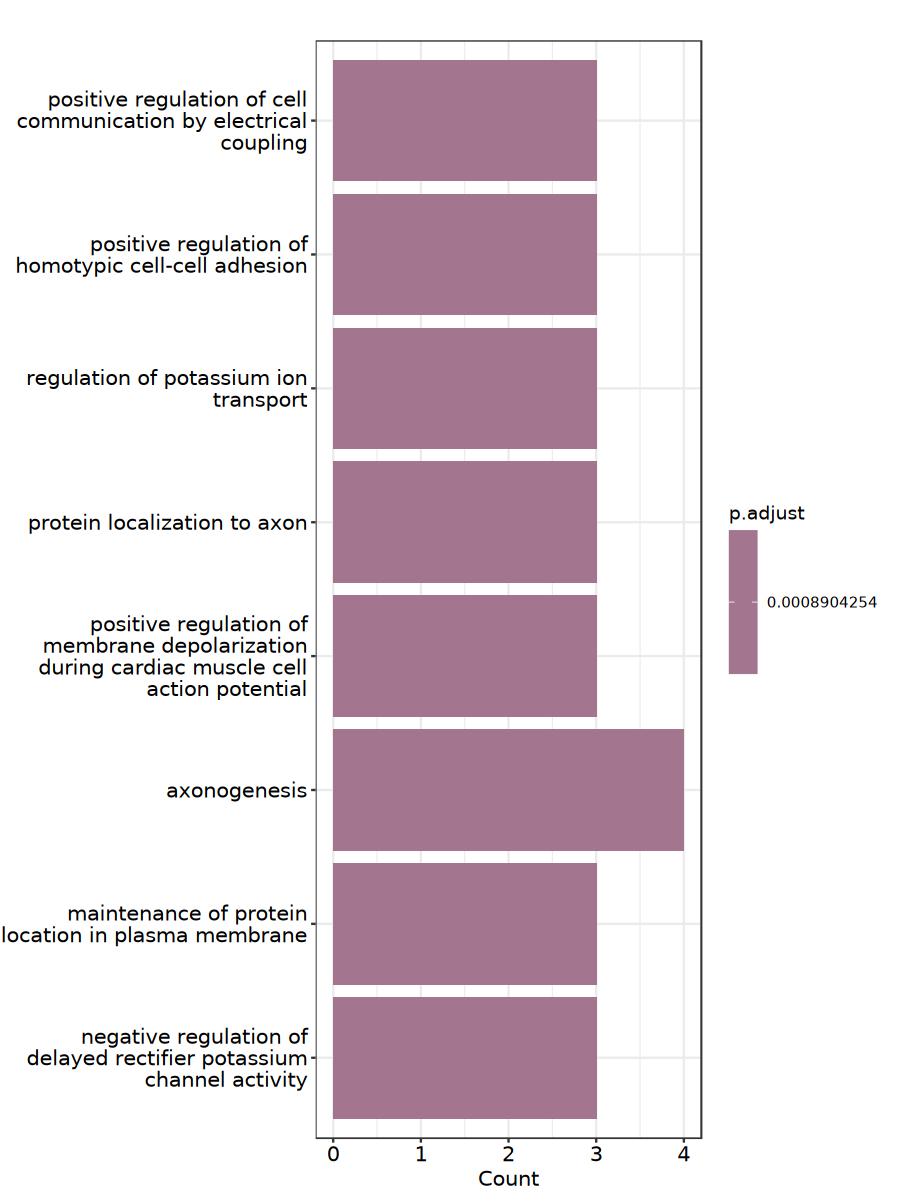

In [30]:
options(repr.plot.width=7.5, repr.plot.height=10)

barplot(res_sig.cc.cw)

looks like some terms involved in signalling (cell-cell adhesion, communication) but also some terms related to neurons

In [20]:
# CC vs. CH
res_sig.cc.ch <- enricher(
    gene = all_df$ch_cc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.cc.ch))

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>


no enriched/over-represented GO terms

In [21]:
# CC vs. CB
res_sig.cc.cb <- enricher(
    gene = all_df$cb_cc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.cc.cb))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0051537,GO:0051537,"2 iron, 2 sulfur cluster binding",3/51,35/16641,0.0001656261,0.03657174,0.02643594,LOC111123314/LOC111127059/LOC111126872,3
GO:0016491,GO:0016491,oxidoreductase activity,5/51,182/16641,0.0002314667,0.03657174,0.02643594,LOC111127059/LOC111137386/LOC111137388/LOC111136642/LOC111106942,5
GO:0055078,GO:0055078,sodium ion homeostasis,2/51,10/16641,0.0004079407,0.03694942,0.02670894,LOC111118161/LOC111118627,2
GO:0044325,GO:0044325,transmembrane transporter binding,5/51,231/16641,0.0006893266,0.03694942,0.02670894,LOC111133968/LOC111100764/LOC111108482/LOC111110117/LOC111113824,5
GO:0014731,GO:0014731,spectrin-associated cytoskeleton,4/51,135/16641,0.0007704427,0.03694942,0.02670894,LOC111133968/LOC111100764/LOC111108482/LOC111113824,4
GO:0015385,GO:0015385,sodium:proton antiporter activity,2/51,14/16641,0.0008184997,0.03694942,0.02670894,LOC111118161/LOC111118627,2


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


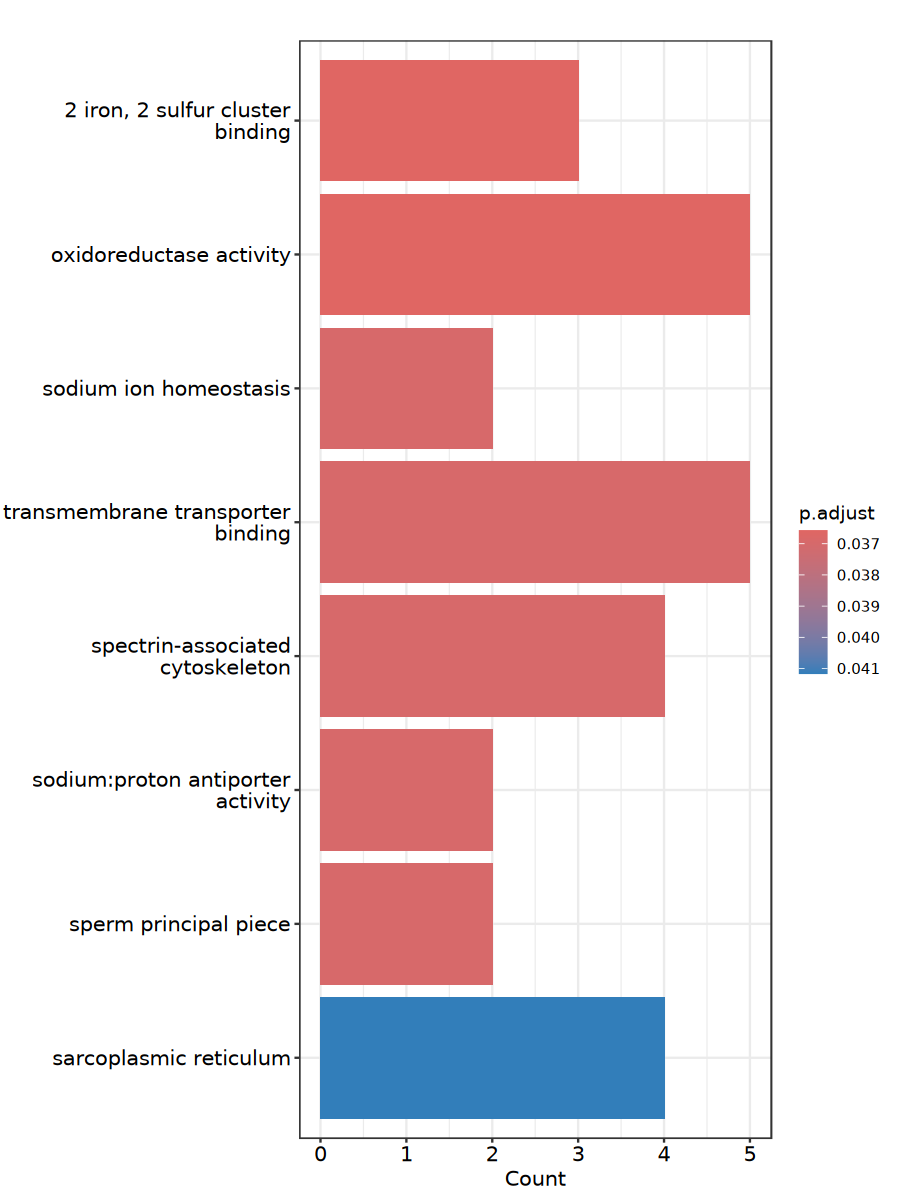

In [31]:
barplot(res_sig.cc.cb)

see terms related to structural processes  (cyotskeleton) but also see oxidoreductase which is involved in redox reactions (vital for metabolism and energy production)

### 3. Effect of timing of initial stress exposure
- WC vs. CW
- HC vs. CH
- BC vs. CB

In [32]:
# WC vs. CW
res_sig.wc.cw <- enricher(
    gene = all_df$cw_wc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.wc.cw))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0008093,GO:0008093,cytoskeletal anchor activity,6/41,121/16641,4.764237e-07,0.0001080404,6.211965e-05,LOC111100764/LOC111107865/LOC111112084/LOC111113824/LOC111113858/LOC111110817,6
GO:0014731,GO:0014731,spectrin-associated cytoskeleton,6/41,135/16641,9.079026e-07,0.0001080404,6.211965e-05,LOC111100764/LOC111107865/LOC111112084/LOC111113824/LOC111113858/LOC111110817,6
GO:0016529,GO:0016529,sarcoplasmic reticulum,6/41,154/16641,1.960415e-06,0.0001493782,8.588753e-05,LOC111100764/LOC111107865/LOC111112084/LOC111113824/LOC111113858/LOC111110817,6
GO:0030507,GO:0030507,spectrin binding,6/41,161/16641,2.538419e-06,0.0001493782,8.588753e-05,LOC111100764/LOC111107865/LOC111112084/LOC111113824/LOC111113858/LOC111110817,6
GO:0005200,GO:0005200,structural constituent of cytoskeleton,6/41,167/16641,3.138198e-06,0.0001493782,8.588753e-05,LOC111100764/LOC111107865/LOC111112084/LOC111113824/LOC111113858/LOC111110817,6
GO:0070469,GO:0070469,respirasome,3/41,13/16641,3.902754e-06,0.0001548092,8.901017e-05,LOC111119097/LOC111119236/LOC111125731,3


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


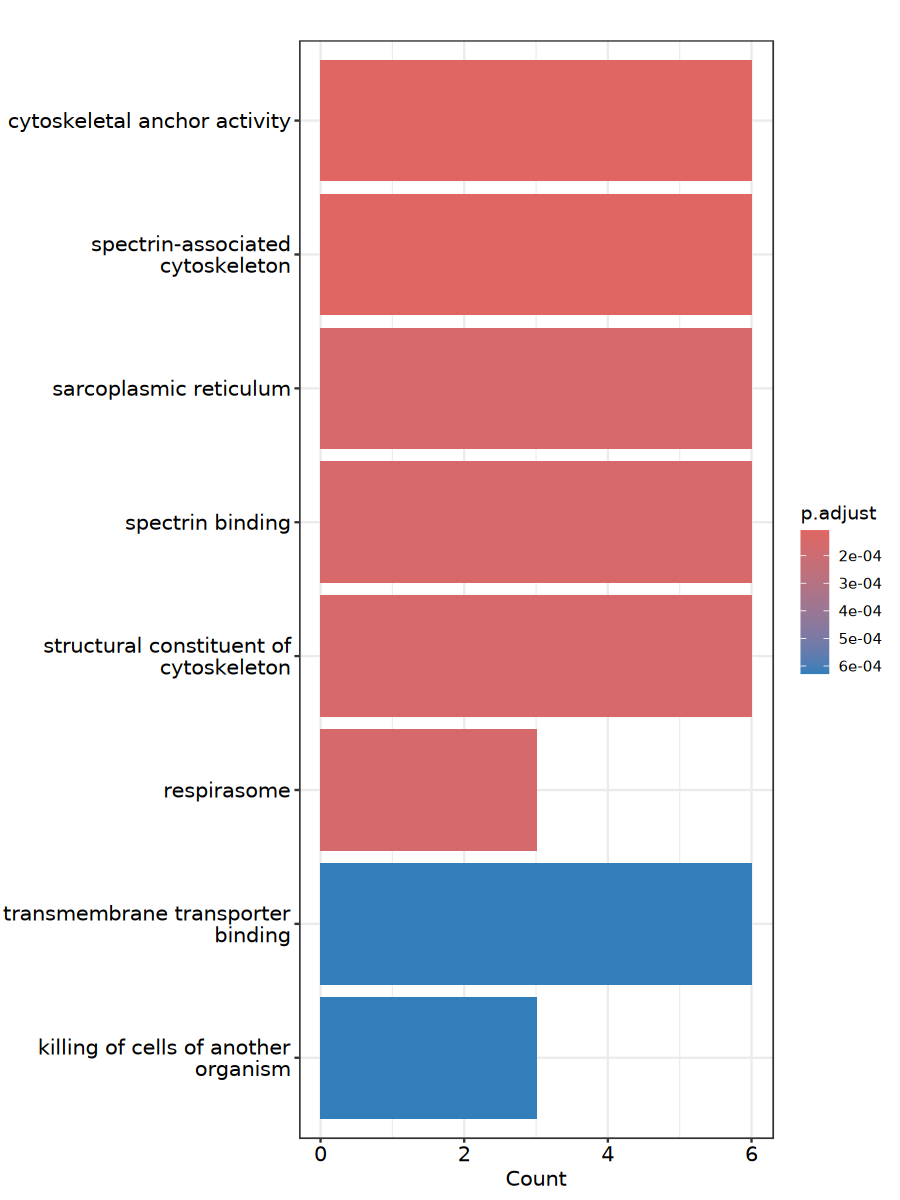

In [34]:
barplot(res_sig.wc.cw)

In [36]:
# HC vs. CH
res_sig.hc.ch <- enricher(
    gene = all_df$ch_hc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.hc.ch))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0031232,GO:0031232,extrinsic component of external side of plasma membrane,3/49,34/16641,0.0001346355,0.02919772,0.01959445,LOC111123495/LOC111104743/LOC111108101,3
GO:0009725,GO:0009725,response to hormone,3/49,47/16641,0.0003551450,0.02919772,0.01959445,LOC111104716/LOC111110558/LOC111110387,3
GO:0098632,GO:0098632,cell-cell adhesion mediator activity,2/49,10/16641,0.0003765067,0.02919772,0.01959445,LOC111125416/LOC111125415,2
GO:0062023,GO:0062023,collagen-containing extracellular matrix,6/49,344/16641,0.0004937195,0.02919772,0.01959445,LOC111105495/LOC111137636/LOC111104743/LOC111108101/LOC111111748/LOC111116035,6
GO:0005595,GO:0005595,collagen type XII trimer,2/49,12/16641,0.0005501353,0.02919772,0.01959445,LOC111105495/LOC111137636,2
GO:1904706,GO:1904706,negative regulation of vascular associated smooth muscle cell proliferation,2/49,13/16641,0.0006489379,0.02919772,0.01959445,LOC111110558/LOC111110387,2


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


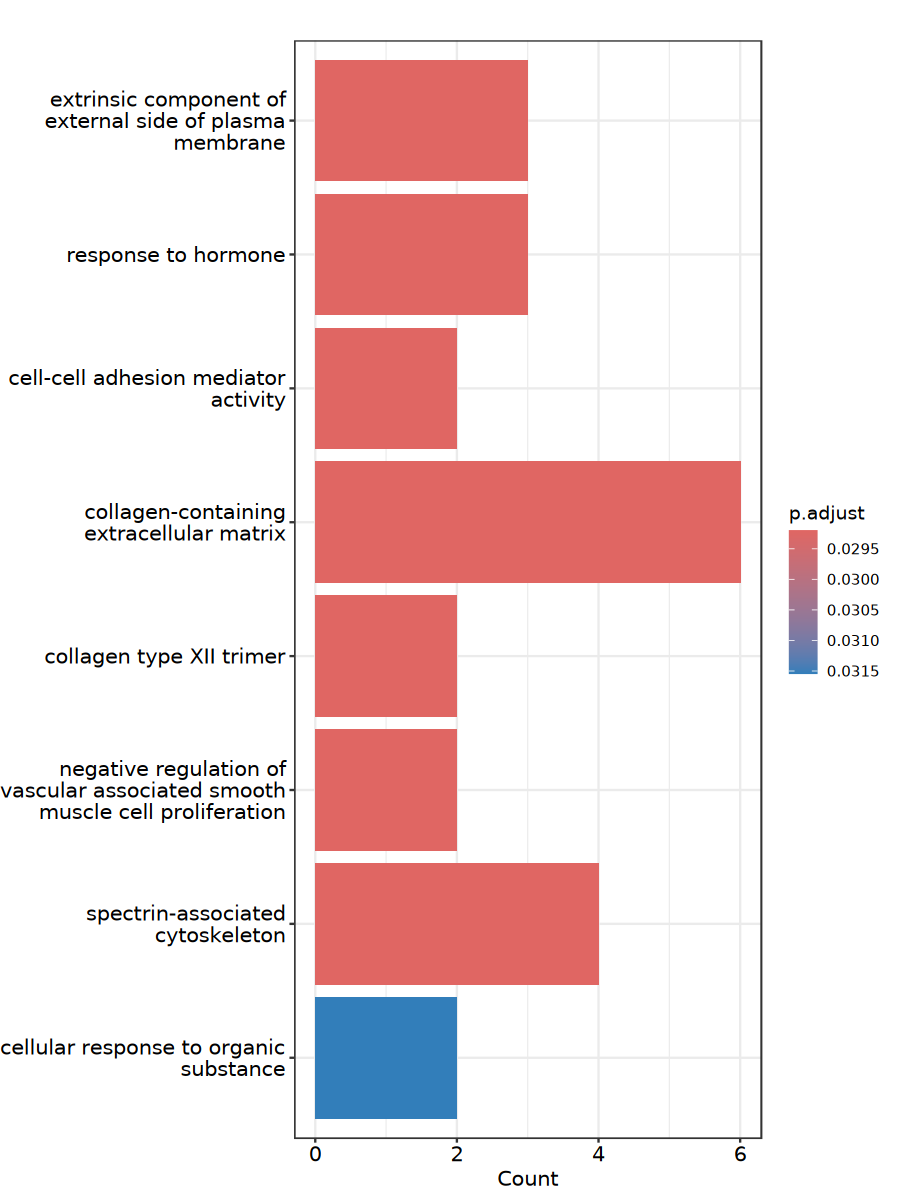

In [37]:
barplot(res_sig.hc.ch)

lots of signaling terms, some development (in terms of muscle cell proliferation), and some structural processes (cytoskeleton)

In [38]:
# BC vs. CB
res_sig.bc.cb <- enricher(
    gene = all_df$cb_bc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.bc.cb))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0001758,GO:0001758,retinal dehydrogenase activity,5/244,10/16641,1.544066e-07,0.0001588844,0.0001448172,LOC111128910/LOC111109438/LOC111109436/LOC111109441/LOC111109442,5
GO:0016298,GO:0016298,lipase activity,5/244,17/16641,3.485686e-06,0.0015969790,0.0014555862,LOC111118134/LOC111123216/LOC111134948/LOC111134947/LOC111103330,5
GO:0016042,GO:0016042,lipid catabolic process,9/244,86/16641,4.655915e-06,0.0015969790,0.0014555862,LOC111136736/LOC111118134/LOC111123216/LOC111134948/LOC111134947/LOC111137030/LOC111133423/LOC111103330/LOC111103450,9
GO:0005764,GO:0005764,lysosome,18/244,368/16641,8.643575e-06,0.0022235598,0.0020266910,LOC111109550/LOC111125505/LOC111119850/LOC111126259/LOC111125418/LOC111129386/LOC111128921/LOC111134948/LOC111134947/LOC111133671/LOC111103199/LOC111103198/LOC111103450/LOC111102947/LOC111109438/LOC111109436/LOC111109441/LOC111109442,18
GO:0002682,GO:0002682,regulation of immune system process,4/244,11/16641,1.372588e-05,0.0023539879,0.0021455713,LOC111133671/LOC111103199/LOC111103198/LOC111102947,4
GO:0010983,GO:0010983,positive regulation of high-density lipoprotein particle clearance,4/244,11/16641,1.372588e-05,0.0023539879,0.0021455713,LOC111120355/LOC111118284/LOC111118101/LOC111103330,4


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


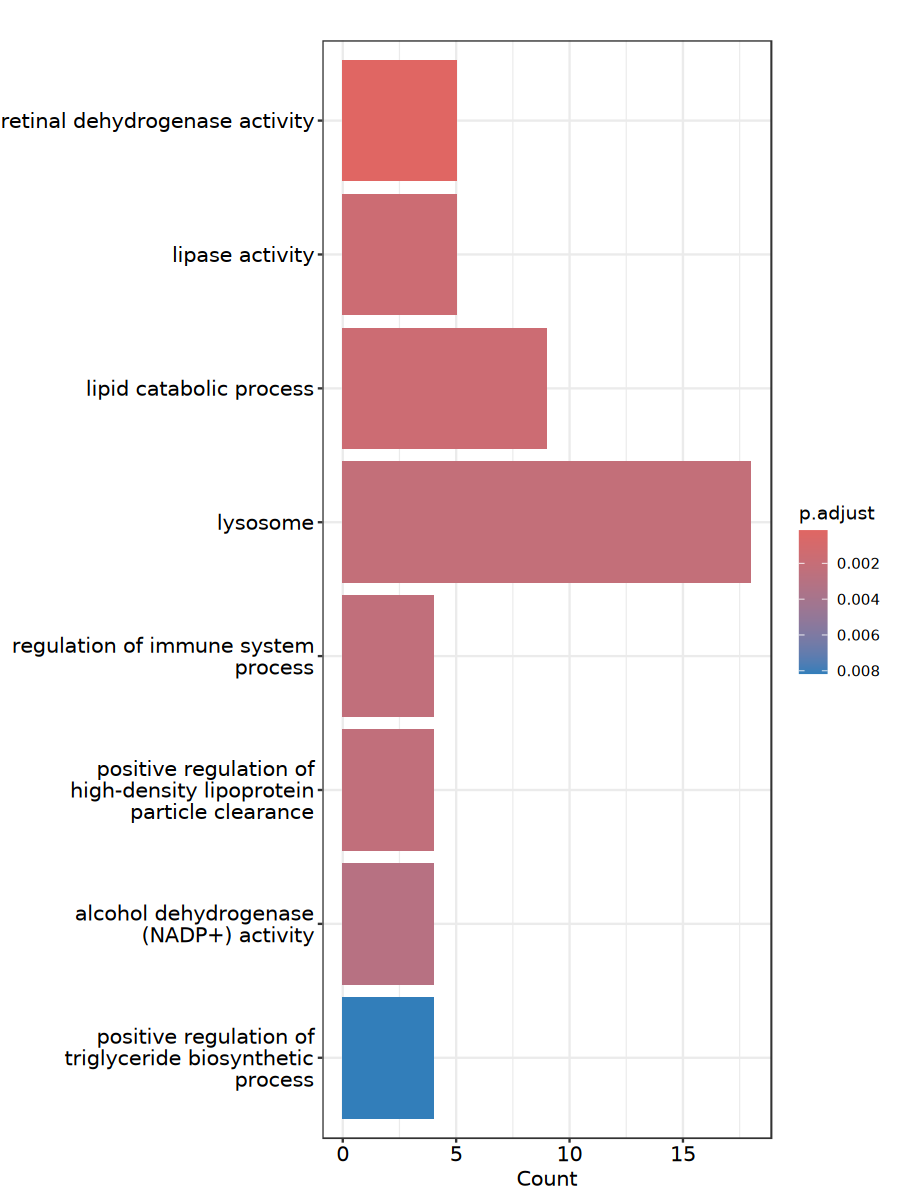

In [39]:
barplot(res_sig.bc.cb)

stress response (in terms of immune response genes) and metabolism (biosynthesis and catabolism)

lipase activity, lipid catabolic process, and lipoprotein are all enriched - lipids store energy, form cell membranes, act as signaling molecules